### Reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

### In general transfer learning follows following steps
* Initialize the pretrained model 
* Reshape the final layers to have the same number of outputs as the number of classes in the new dataset
* Define for the optimization algorithm which parameters we want to update during training 
* Run the training step


In [2]:
from __future__ import print_function
from __future__ import division
import torch 
import torch.nn as nn 
import torch.optim as optim
import numpy as np 
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
import copy 

### Using hymenoptera_dataset for testing the efficiency of finetuining. This dataset contains two classes, bees and aunts

In [3]:
# data directory 
data_dir = '../datasets/hymenoptera_data'

# models[* Torch provides pretraind weights for resnet, alexnet, vgg, squeezenet, densenet, inception*]
model_name = 'resnet'

# number of classes
num_classes = 2

# batch size for training 
batch_size = 8 

# number of epochs
num_epochs = 10 

# flag for feature extracting. When false, we finetune the whole model, 
# when true we only update the reshaped layer params
# feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True only the last layer parameters are updated, the other remains fixed.
feature_extract = True

### Model Training and Validation 

In [33]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    
    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'* 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # validation mode
            
            running_loss = 0.0
            running_corrects = 0 
            
            # Iteration over data 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameters gradients
                optimizer.zero_grad()
                
                # forward propagation
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)
                     
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc : {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history
                    

### Helper function for required_grad attribute
* By default when we load a pretrained model all of the parameters have .requires_grad = True, which is fine if we are training from scratch or finetuining. 
* But, if we are feature extratcing and only want to compute gradients for the newly initilized layer then we want all of the other parameters to not require gradients.

In [27]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

### Initialize and Reshape the Network

* All of the models have been pretrained on ImageNet and they all have output layers of size 1000, one node for each class. So, we need to reshape the last layer to have the same number of inputs as before, and to have the same number of outputs as the number of classes in the dataset.

In [28]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    #variables // model specific
    model_ft = None
    input_size = 0 
    
    if model_name == 'resnet':
    
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
        
    else:
        print('Invalid model name')
        exit()
        
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)
    

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Load Data


In [29]:
# Data augumentation and normalization for training 
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print('Initializing Datasets and Dataloaders')

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4) for x in ['train', 'val']}

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



Initializing Datasets and Dataloaders


In [30]:
device

device(type='cuda', index=0)

### Creating the optimizer
* This is the final step for finetuning and feature extraction which updates the desired parameters. 
* We set the .requires_grad to False(Default was True) lets check the difference

In [31]:
# Sending the model to GPU
model_ft = model_ft.to(device)

# if we are fine tuining we will update all parameters
## if we are doing feature extraction we will only update the parameters that we have just initialized

params_to_update = model_ft.parameters()
print('Params to Learn')
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)
        else:
            for name, param in model_ft.named_parameters():
                if param.requires_grad == True:
                    print('\t', name)
optimizer_ft = optim.SGD(params_to_update, lr = 0.001, momentum=0.9)

Params to Learn
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc.bias
	 fc.weight
	 fc

In [34]:
# setup the loss function
criterion = nn.CrossEntropyLoss()

#train and evaluate 
model_ft, hist = train_model(model_ft,
                             dataloaders_dict,
                             criterion,
                             optimizer_ft,
                             num_epochs= num_epochs)

Epoch 0/9
----------
train Loss: 0.3049 Acc: 0.8689
val Loss: 0.2583 Acc: 0.9085

Epoch 1/9
----------
train Loss: 0.2982 Acc: 0.8934
val Loss: 0.2212 Acc: 0.9346

Epoch 2/9
----------
train Loss: 0.3377 Acc: 0.8566
val Loss: 0.1988 Acc: 0.9346

Epoch 3/9
----------
train Loss: 0.2653 Acc: 0.9016
val Loss: 0.2049 Acc: 0.9542

Epoch 4/9
----------
train Loss: 0.1672 Acc: 0.9344
val Loss: 0.2055 Acc: 0.9477

Epoch 5/9
----------
train Loss: 0.2369 Acc: 0.8811
val Loss: 0.3004 Acc: 0.9020

Epoch 6/9
----------
train Loss: 0.2837 Acc: 0.8607
val Loss: 0.2407 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.2853 Acc: 0.8770
val Loss: 0.2308 Acc: 0.9477

Epoch 8/9
----------
train Loss: 0.2356 Acc: 0.9098
val Loss: 0.2123 Acc: 0.9346

Epoch 9/9
----------
train Loss: 0.3237 Acc: 0.8566
val Loss: 0.4751 Acc: 0.8431

Training complete in 0m 31s
Best val Acc : 0.954248


Epoch 0/9
----------
train Loss: 0.6741 Acc: 0.5779
val Loss: 0.6909 Acc: 0.6209

Epoch 1/9
----------
train Loss: 0.7248 Acc: 0.5943
val Loss: 0.6406 Acc: 0.6536

Epoch 2/9
----------
train Loss: 0.6566 Acc: 0.5943
val Loss: 0.5737 Acc: 0.7255

Epoch 3/9
----------
train Loss: 0.6138 Acc: 0.6762
val Loss: 0.7148 Acc: 0.6928

Epoch 4/9
----------
train Loss: 0.6864 Acc: 0.6680
val Loss: 0.7179 Acc: 0.5817

Epoch 5/9
----------
train Loss: 0.6651 Acc: 0.6311
val Loss: 0.6115 Acc: 0.7059

Epoch 6/9
----------
train Loss: 0.5944 Acc: 0.7049
val Loss: 0.7318 Acc: 0.5752

Epoch 7/9
----------
train Loss: 0.7260 Acc: 0.6393
val Loss: 1.0040 Acc: 0.5556

Epoch 8/9
----------
train Loss: 0.6391 Acc: 0.6885
val Loss: 0.8206 Acc: 0.5490

Epoch 9/9
----------
train Loss: 0.6408 Acc: 0.6680
val Loss: 0.6647 Acc: 0.6340

Training complete in 0m 31s
Best val Acc : 0.725490


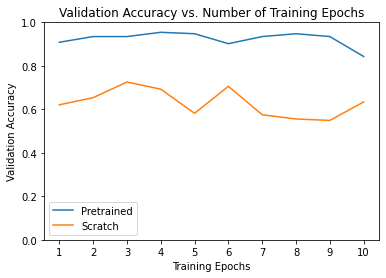

In [36]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, 
                             dataloaders_dict, 
                             scratch_criterion, 
                             scratch_optimizer, 
                             num_epochs=num_epochs)

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()